# Example 10 Time-dependent reduced density

**This example takes a while. I recommend execution on HPC and select JAX as wrapper**

In [1]:
!nvidia-smi
__debug__

zsh:1: command not found: nvidia-smi


True

In [2]:
import platform
import sys

import pytdscf

print(sys.version)
print(f"pytdscf version = {pytdscf.__version__}")
print(platform.platform())

from jax.lib import xla_bridge

print(xla_bridge.get_backend().platform)

3.12.2 (main, Feb  6 2024, 20:19:44) [Clang 15.0.0 (clang-1500.1.0.2.5)]
pytdscf version = 1.0.3
macOS-14.4.1-arm64-arm-64bit
cpu


/var/folders/sj/nm7r7k8969b31b686cw52trh0000gn/T/ipykernel_65243/1544164112.py:12: DeprecationWarning: jax.lib.xla_bridge.get_backend is deprecated; use jax.extend.backend.get_backend.
  print(xla_bridge.get_backend().platform)


In [3]:
import matplotlib.pyplot as plt
import numpy as np
from discvar import Exponential, HarmonicOscillator, Sine

from pytdscf import BasInfo, Model, Simulator, units
from pytdscf.hamiltonian_cls import TensorHamiltonian

$$
\begin{align}
\hat{H} &= 
\left[-\frac{1}{2} \frac{\partial^2}{\partial Q_0^2}
- \frac{1}{2I} \frac{\partial^2}{\partial \theta_1^2}
- \sum_{j=2}^{24} \frac{1}{2} \frac{\partial^2}{\partial Q_{j}^2}
\right]
\begin{pmatrix}
1 & 0 \\
0 & 1
\end{pmatrix}
\\
&+
\begin{pmatrix}
D_e\left(1-\exp\left(-\sqrt{\frac{\Omega^2}{2D_e}}Q_0^2\right)\right)^2 & \lambda Q_0 \\
\lambda Q_0 & D_e\left(1-\exp\left(-\sqrt{\frac{\Omega^2}{2D_e}}(Q_0-Q_{\mathrm{ref}})^2\right)\right)^2 +E
\end{pmatrix}
\\
&+
\begin{pmatrix}
\frac{W_0}{2}\left(1-\cos\theta_1\right) & 0\\
0 & -\frac{W_1}{2}\left(1-\cos\theta_1\right)
\end{pmatrix}
\\
&+\sum_{j=2}^{24} 
\begin{pmatrix}
\frac{\omega_j^2}{2}Q_j^2 & 0 \\
0 & \frac{\omega_j^2}{2}Q_j^2+ \kappa_j Q_j
\end{pmatrix}
\end{align}
$$

References:

- [Johnson, Philip JM, et al. "The primary photochemistry of vision occurs at the molecular speed limit." The Journal of Physical Chemistry B 121.16 (2017): 4040-4047.](https://pubs.acs.org/doi/epdf/10.1021/acs.jpcb.7b02329)

- Morse potential is our original demonstration.


In [4]:
backend = "numpy"
Ω = 1532 / units.au_in_cm1  # Frequency of C=C stretching
K = 0.19 / units.au_in_eV
Q_ref = K / (Ω**1.5)
De = 2.285278e-1  # Dissociation energy 2.285278E-1 Eh = 600 kJ /mol
I = 1 / (
    4.84e-04 / units.au_in_eV
)  # inertial mass　of C=C torsion (isomerization)
W0 = 3.56 / units.au_in_eV  # isomerization term
W1 = 1.19 / units.au_in_eV  # isomerization term
λ = 0.19 / units.au_in_eV  # Linear vibronic coupling term
E = 2.58 / units.au_in_eV - K**2 / 2 / Ω

use_bath = True

if use_bath:
    bath_ω = (
        np.array(
            [
                792.8,
                842.8,
                866.2,
                882.4,
                970.3,
                976.0,
                997.0,
                1017.1,
                1089.6,
                1189.0,
                1214.7,
                1238.1,
                1267.9,
                1317.0,
                1359.0,
                1389.0,
                1428.4,
                1434.9,
                1451.8,
                1572.8,
                1612.1,
                1629.2,
                1659.1,
            ]
        )
        / units.au_in_cm1
    )

    dimless_displace = np.array(
        [
            0.175,
            0.2,
            0.175,
            0.225,
            0.55,
            0.3,
            0.33,
            0.45,
            0.125,
            0.175,
            0.44,
            0.5,
            0.475,
            0.238,
            0.25,
            0.25,
            0.25,
            0.225,
            0.225,
            0.25,
            0.225,
            0.125,
            0.225,
        ]
    )  # c=κ/ω

In [5]:
basis = [
    Sine(ngrid=2**6, length=175.0, x0=-55.0, units="a.u."),
    Exponential(ngrid=2**8 - 1, length=2 * np.pi, x0=-np.pi),
]
if use_bath:
    for ω, c in zip(bath_ω, dimless_displace, strict=False):
        ho_grids = HarmonicOscillator(10, ω, units="a.u.").get_grids()
        left_grid = ho_grids[0] - c / np.sqrt(ω)
        length = ho_grids[-1] - ho_grids[0] + c / np.sqrt(ω)  ## c=κ/ω
        basis.append(
            Sine(ngrid=2**5, length=length, x0=left_grid, units="a.u.")
        )
basinfo = BasInfo([basis, basis])

In [6]:
s1_func = {}
s1_func[(0,)] = (
    lambda Q0: De
    * (1.0 - np.exp(-1.0 * np.sqrt(Ω**2 / 2.0 / De) * (Q0 - Q_ref))) ** 2
)
s1_func[(1,)] = lambda θ1: -W1 / 2.0 * (1.0 - np.cos(θ1))
s0_func = {}
s0_func[(0,)] = (
    lambda Q0: De * (1.0 - np.exp(-1.0 * np.sqrt(Ω**2 / 2.0 / De) * Q0)) ** 2
)
s0_func[(1,)] = lambda θ1: W0 / 2.0 * (1.0 - np.cos(θ1))
v01_func = {}
v01_func[(0,)] = lambda Q0: λ * np.sqrt(Ω) * Q0
if use_bath:
    for i in range(len(bath_ω)):
        # Be careful to late binding
        s0_func[(i + 2,)] = lambda Qi, i=i: bath_ω[i]**2 / 2 * Qi**2
        s1_func[(i + 2,)] = lambda Qi, i=i: bath_ω[i]**2 / 2 * Qi**2 + dimless_displace[i] * (bath_ω[i]**1.5) * Qi

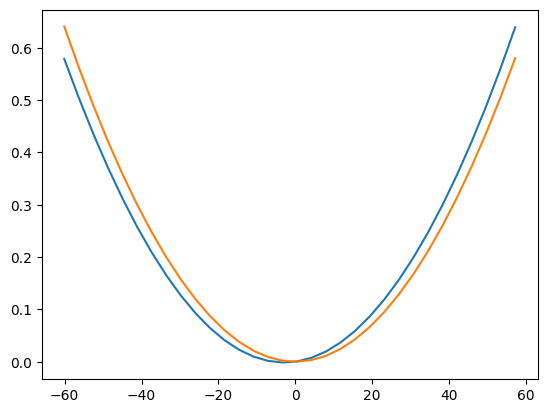

In [7]:
if use_bath:
    plt.plot(
        x := np.array(basis[2].get_grids()), (s1_func[(2,)](x)) * units.au_in_eV
    )
    plt.plot(
        x := np.array(basis[2].get_grids()), s0_func[(2,)](x) * units.au_in_eV
    )
    plt.show()

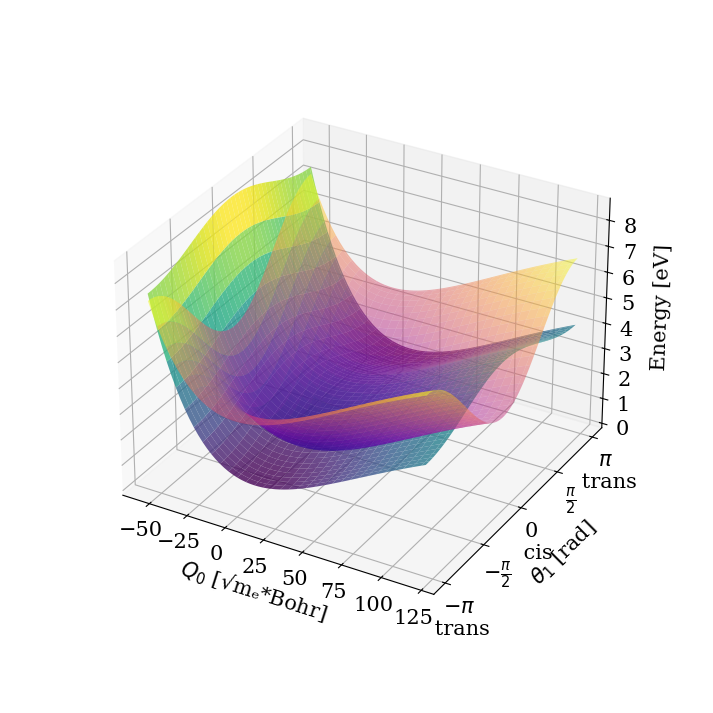

In [8]:
def S1(Q, θ):
    return s1_func[(0,)](Q) + s1_func[(1,)](θ) + E


def S0(Q, θ):
    return s0_func[(0,)](Q) + s0_func[(1,)](θ)


plt.rcParams["font.size"] = 15
plt.rcParams["font.family"] = "DejaVu Serif"
Q, θ = np.meshgrid(basis[0].get_grids(), basis[1].get_grids())
V11 = (S1(Q, θ)) * units.au_in_eV
V00 = (S0(Q, θ)) * units.au_in_eV
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection="3d")
ax.set_xlabel("$Q_0$ [√mₑ*Bohr]")
ax.xaxis.labelpad = 10
ax.set_ylabel(r"$\theta_1$ [rad]")
ax.yaxis.labelpad = 15
ax.set_zlabel("Energy [eV]")
ax.zaxis.labelpad = 10
ax.set_yticks(
    [-np.pi, -np.pi / 2.0, 0.0, np.pi / 2.0, np.pi],
    [
        "$-\\pi$ \n trans",
        r"$-\frac{\pi}{2}$",
        "0 \n cis",
        r"$\frac{\pi}{2}$",
        "$\\pi$ \n trans",
    ],
)
surf = ax.plot_surface(Q, θ, V00, cmap="plasma", alpha=0.5)
surf = ax.plot_surface(Q, θ, V11, cmap="viridis", alpha=0.8)
ax.set_box_aspect(aspect=None, zoom=0.8)
plt.show()

In [9]:
from pytdscf.dvr_operator_cls import (
    TensorOperator,
    construct_kinetic_operator,
    construct_nMR_recursive,
)

mpo_11 = construct_nMR_recursive(basis, nMR=1, func=s1_func, rate=0.99999999999)
mpo_00 = construct_nMR_recursive(basis, nMR=1, func=s0_func, rate=0.99999999999)
mpo_01 = construct_nMR_recursive(
    basis[0:1], nMR=1, func=v01_func, rate=0.99999999999
)

In [10]:
# MPO has legs on (0,1,2, ... ,f-1) sites. This legs are given by tuple key
V11 = {tuple([k for k in range(len(basis))]): TensorOperator(mpo=mpo_11)}
V00 = {tuple([k for k in range(len(basis))]): TensorOperator(mpo=mpo_00)}
V01 = {(0,): TensorOperator(mpo=mpo_01, legs=(0,))}

# constant shift term is given by empty () which means no legs of tensor
Eshift = 0.0 / units.au_in_eV
coupleJ = [[-Eshift, 0], [0, E - Eshift]]
V11[()] = coupleJ[1][1]
V00[()] = coupleJ[0][0]
V01[()] = coupleJ[0][1]

potential = [[V00, V01], [V01, V11]]

# Kinetic energy operator is given by
K00 = construct_kinetic_operator(
    basis, coefs=[1.0, 1.0 / I] + [1.0] * (len(basis) - 2)
)
kinetic = [[K00, None], [None, K00]]

H = TensorHamiltonian(
    ndof=len(basis), potential=potential, kinetic=kinetic, backend=backend
)

operators = {"hamiltonian": H}

In [11]:
model = Model(basinfo=basinfo, operators=operators)
model.m_aux_max = 20

In [12]:
import numpy as np


def get_initial_state(ω, x):
    weight = np.exp(-ω / 2 * (np.array(x)) ** 2)
    weight /= np.linalg.norm(weight)
    return weight.tolist()


ω_list = [Ω, 2 / (0.15228**2)]
if use_bath:
    ω_list += bath_ω.tolist()
# I wonder where 0.15228 comes from???
# but https://pubs.acs.org/doi/epdf/10.1021/acs.jctc.2c00209 adopts this value
# as an initial Gaussian width of the torsional mode

init_vib = [
    get_initial_state(ω, bas.get_grids())
    for ω, bas in zip(ω_list, basis, strict=True)
]
model.init_weight_VIBSTATE = [init_vib, init_vib]
model.init_weight_ESTATE = [0.0, 1.0]

In [ ]:
jobname = "isomerization"
if use_bath:
    jobname += "_bath"
simulator = Simulator(jobname=jobname, model=model, backend=backend, verbose=2)
simulator.propagate(
    maxstep=4000,
    stepsize=0.05,
    reduced_density=([(0, 1)], 40),
    energy=False,
    autocorr=False,
)
# calculate (0,1) reduced density every 20 steps

2024-11-28 12:53:56,164 - INFO:main.pytdscf._const_cls - 
     ____     __________   .____ ____   _____
    / _  |   /__  __/ _ \ / ___ / _  \ / ___/
   / /_) /_  __/ / / / ||/ /__ / / )_// /__
  /  ___/ / / / / / / / |.__  / |  __/ ___/
 /  /  / /_/ / / / /_/ /___/ /| \_/ / /
/__/   \__, /_/ /_____/_____/ \____/_/
      /____/

2024-11-28 12:53:56,164 - INFO:main.pytdscf._const_cls - Log file is ./isomerization_bath_prop/main.log
2024-11-28 12:53:56,165 - INFO:main.pytdscf.simulator_cls - Set integral of DVR basis
2024-11-28 12:53:56,166 - INFO:main.pytdscf.simulator_cls - Set initial wave function (DVR basis)
2024-11-28 12:53:56,166 - INFO:main.pytdscf.simulator_cls - Prepare MPS w.f.
2024-11-28 12:53:56,166 - INFO:main.pytdscf._mps_cls - Initial MPS: 0-state with weights 0.0
2024-11-28 12:53:56,167 - INFO:main.pytdscf._mps_cls - Initial MPS: 1-state with weights 1.0
2024-11-28 12:53:56,212 - INFO:main.pytdscf.simulator_cls - Wave function is saved in wf_isomerization_bath.pkl
2024-1

In [ ]:
import netCDF4 as nc
from matplotlib.animation import FuncAnimation

with nc.Dataset(f"{jobname}_prop/reduced_density.nc", "r") as file:
    density_data_S1 = file.variables["rho_(0, 1)_1"][:]
    density_data_S0 = file.variables["rho_(0, 1)_0"][:]
    time_data = file.variables["time"][:]
    print(time_data.shape)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 6))


def update(i):
    ax0.cla()
    ax1.cla()
    im0 = ax0.contour(
        Q,
        θ,
        density_data_S0[i, :, :].T,
        levels=[1.0e-05, 1.0e-04, 1.0e-03],
        colors=["lightblue", "deepskyblue", "navy"],
    )
    # cmap='jet', vmin=0, vmax=0.05, )
    im1 = ax1.contour(
        Q,
        θ,
        density_data_S1[i, :, :].T,
        levels=[1.0e-05, 1.0e-04, 1.0e-03],
        colors=["lightblue", "deepskyblue", "navy"],
    )
    # fix coordinate of title
    fig.suptitle(f"time = {time_data[i]:4.2f} [fs]")
    ax0.set_title(f"S0 \n population = {np.sum(density_data_S0[i]):0.2f}")
    ax1.set_title(f"S1 \n population = {np.sum(density_data_S1[i]):0.2f}")
    ax0.set_xlabel("mass-weighted $Q_0$ [a.u.]")
    ax1.set_xlabel("mass-weighted $Q_0$ [a.u.]")
    ax0.set_ylabel(r"$\theta_1$ [rad]")
    ax1.set_ylabel(r"$\theta_1$ [rad]")
    ax0.set_yticks(
        [-np.pi, -np.pi / 2.0, 0.0, np.pi / 2.0, np.pi],
        [
            "$-\\pi$ \n trans",
            r"$-\frac{\pi}{2}$",
            "0 \n cis",
            r"$\frac{\pi}{2}$",
            "$\\pi$ \n trans",
        ],
    )
    ax1.set_yticks(
        [-np.pi, -np.pi / 2.0, 0.0, np.pi / 2.0, np.pi],
        [
            "$-\\pi$ \n trans",
            r"$-\frac{\pi}{2}$",
            "0 \n cis",
            r"$\frac{\pi}{2}$",
            "$\\pi$ \n trans",
        ],
    )
    return im0, im1


anim = FuncAnimation(fig, update, frames=range(0, len(time_data)), interval=100)
if use_bath:
    gif_name = "reduced_density_bath.gif"
else:
    gif_name = "reduced_density_zerotemp.gif"
anim.save(gif_name, writer="pillow")